In [ ]:
#!pip install medmnist

In [1]:
from tqdm import tqdm                                  # type: ignore
import numpy as np                                     # type: ignore
import torch                                           # type: ignore
import torch.nn as nn                                  # type: ignore
import torch.optim as optim                            # type: ignore
import torch.utils.data as data                        # type: ignore
import torchvision
import torchvision.transforms as transforms            # type: ignore
import torch.nn.functional as F
import matplotlib.pyplot as plt                        # type: ignore

from medmnist import INFO                              # type: ignore
from medmnist import BloodMNIST                        # type: ignore

from prettytable import PrettyTable

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # type: ignore

import warnings
warnings.filterwarnings('ignore')

# Global Variables

In [2]:
data_flag = 'bloodmnist'

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DOWNLOAD = True
NUM_EPOCHS = 20
BATCH_SIZE = 4
LR = 0.001

mapping = {0: 'Basófilos',  1: 'Eosinófilos', 2: 'Eritroblastos', 3: 'Granulocitos i.',
           4: 'Linfócitos', 5: 'Monócitos',   6: 'Neutrófilos',   7: 'Plaquetas'}

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = BloodMNIST(split="train", download=DOWNLOAD, transform=data_transform)
val_dataset = BloodMNIST(split="val", download=DOWNLOAD, transform=data_transform)
test_dataset = BloodMNIST(split="test", download=DOWNLOAD, transform=data_transform)

Using downloaded and verified file: C:\Users\Marck\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Marck\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Marck\.medmnist\bloodmnist.npz


# Function Definition

In [4]:
def plot_loss_function(trainloss, valloss, title):
  plt.plot(trainloss, label='Training Loss', color='blue', ls='dashed')
  plt.plot(valloss, label='Validation Loss', color='red', ls='dashed')
  plt.legend(frameon=False)
  plt.title(title, weight='bold')
  plt.xticks(np.arange(0, NUM_EPOCHS, 2))
  plt.show()

In [5]:
def get_accuracy(data_loader, model):
  if data_loader == valloader:
    loader = 'VALIDATION'
  else:
    loader = 'TESTING'

  correct = 0
  total = 0
  with torch.no_grad():
      for data in data_loader:
          images, labels = data
          labels = labels.squeeze(1)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Total Accuracy in {len(data_loader)*BATCH_SIZE} {loader} images: {round(100 * correct / total, 3)} %')

In [6]:
def print_class_accuracy_table(loader, model):
  myTable = PrettyTable(["Class Cell", "Accuracy"])

  # prepare to count predictions for each class
  classes = list(mapping.values())

  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for data in loader:
          images, labels = data
          labels = labels.squeeze(1)

          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      myTable.add_row([f"{classname:5s}", f"{accuracy:.1f} %"])
      #print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

  print(myTable)

In [7]:
def plot_confusion_matrix(loader, model, title):
  y_pred = []
  y_true = []

  # iterate over test data
  for inputs, labels in loader:
          output = model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  classes = list(mapping.values())

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns=[i for i in classes])
  plt.figure(figsize=(12, 7))
  sns.heatmap(df_cm, annot=True, cmap='YlGnBu', fmt='g',
            annot_kws={"size": 11, "weight": "bold"})
  plt.title(title, weight='bold', fontsize=14)
  plt.yticks(rotation=45, weight='bold')
  plt.xticks(rotation=45, weight='bold')
  plt.xlabel('PREDICTED', weight='bold', fontsize=12)
  plt.ylabel('TRUE', weight='bold', fontsize=12)
  plt.show()

In [8]:
def create_dataloaders(train_dataset, val_dataset, test_dataset, BATCH_SIZE):
  trainloader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                               shuffle=True, num_workers=2)
  valloader   = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, num_workers=2)
  testloader  = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, num_workers=2)

  return trainloader, valloader, testloader

In [9]:
img_cls = list(mapping.keys())
img_list = []

k = 0
for i in range(1711):
    image, label = train_dataset[i]
    if label[0] == img_cls[k]:
        img_list.append(image)
        k += 1

    if k == 8:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


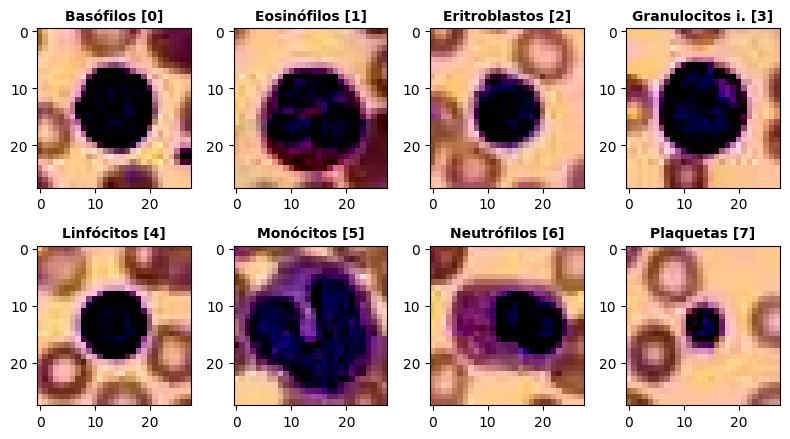

In [10]:
rows, cols = 2, 4
fig, ax = plt.subplots(rows, cols, figsize=(8, 4.5), constrained_layout=True)

k = 0
for r in range(rows):
    for c in range(cols):
        ax[r][c].imshow(np.squeeze(img_list[k].permute(1, 2, 0)), aspect="auto")
        ax[r][c].set_title(f"{mapping[k]} [{img_cls[k]}]", fontsize=10, weight='bold')

        k += 1

plt.tight_layout()
plt.show()

# PART A)

In [ ]:
## a) Aplique uma rede MLP com uma camada intermediária e analise (1) a acurácia e (2) a matriz de confusão para
## os dados de teste obtidas pela melhor versão desta rede. Descreva a metodologia e a arquitetura empregada,
## bem como todas as escolhas feitas.

In [11]:
trainloader, valloader, testloader = create_dataloaders(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

In [12]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*784, 256)
        self.fc2 = nn.Linear(256, 8)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

model_1 = MultiLayerPerceptron()
model_1

MultiLayerPerceptron(
  (fc1): Linear(in_features=2352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
)

In [13]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_1.parameters(), lr=LR, momentum=0.9)

In [14]:
train_losses, val_losses = [], []

# train
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0

    for images, labels in trainloader:
        # calculate log loss probabilities
        outputs = model_1(images)

        labels = labels.squeeze(1)

        # calculate loss
        if task == 'multi-label, binary-class':
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
        else:
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)

        train_total += loss.item()

        # zero gradients
        optimizer.zero_grad()
        # calculate gradients - backward pass
        loss.backward()
        # take a step in direction minimizing loss
        optimizer.step()
    else:
        val_total = 0
        val_correct = 0  # Initialize number of correct predictions on the val set as 0

        # Turn off gradients for validation to save memory and computations
        with torch.no_grad():
            for images, labels in valloader:

                labels = labels.squeeze(1)

                # calculate log loss probabilities
                outputs = model_1(images)
                # calculate loss
                if task == 'multi-label, binary-class':
                    labels = labels.to(torch.float32)
                    loss = criterion(outputs, labels)
                else:
                    labels = labels.squeeze().long()
                    loss = criterion(outputs, labels)
                val_total += loss.item()

                # calculate class probabilities
                ps = torch.exp(outputs)
                # calculate correct predictions
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_correct += equals.sum().item()

        # Calculate average loss between train and test sets
        train_loss = train_total / len(trainloader.dataset)
        val_loss = val_total / len(valloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print("Epoch: {}/{} | ".format(epoch+1, NUM_EPOCHS),
              "Train Loss: {:.5f} | ".format(train_loss),
              "Val Loss: {:.5f} | ".format(val_loss),
              "Val Acc: {:.5f}".format(val_correct / len(valloader.dataset)))

Epoch: 1/20 |  Train Loss: 0.22658 |  Val Loss: 0.18278 |  Val Acc: 0.73248
Epoch: 2/20 |  Train Loss: 0.17643 |  Val Loss: 0.14925 |  Val Acc: 0.78446
Epoch: 3/20 |  Train Loss: 0.16392 |  Val Loss: 0.15375 |  Val Acc: 0.77979
Epoch: 4/20 |  Train Loss: 0.15535 |  Val Loss: 0.13881 |  Val Acc: 0.80841
Epoch: 5/20 |  Train Loss: 0.15125 |  Val Loss: 0.13386 |  Val Acc: 0.80491
Epoch: 6/20 |  Train Loss: 0.14561 |  Val Loss: 0.13734 |  Val Acc: 0.80374
Epoch: 7/20 |  Train Loss: 0.14143 |  Val Loss: 0.18541 |  Val Acc: 0.73189
Epoch: 8/20 |  Train Loss: 0.13831 |  Val Loss: 0.14207 |  Val Acc: 0.79322
Epoch: 9/20 |  Train Loss: 0.13573 |  Val Loss: 0.14133 |  Val Acc: 0.79731
Epoch: 10/20 |  Train Loss: 0.13131 |  Val Loss: 0.15090 |  Val Acc: 0.78446
Epoch: 11/20 |  Train Loss: 0.13053 |  Val Loss: 0.15439 |  Val Acc: 0.78037
Epoch: 12/20 |  Train Loss: 0.12729 |  Val Loss: 0.13135 |  Val Acc: 0.79790
Epoch: 13/20 |  Train Loss: 0.12540 |  Val Loss: 0.13450 |  Val Acc: 0.80607
Epoch: 1

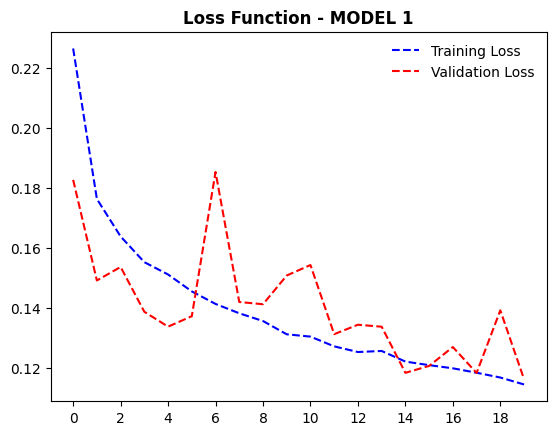

In [15]:
plot_loss_function(train_losses, val_losses, 'Loss Function - MODEL 1')

In [16]:
get_accuracy(valloader, model_1)

Total Accuracy in 1712 VALIDATION images: 83.762 %


In [17]:
get_accuracy(testloader, model_1)

Total Accuracy in 3424 TESTING images: 81.73 %


In [18]:
print_class_accuracy_table(testloader, model_1)

+-----------------+----------+
|    Class Cell   | Accuracy |
+-----------------+----------+
|    Basófilos    |  55.3 %  |
|   Eosinófilos   |  93.9 %  |
|  Eritroblastos  |  88.4 %  |
| Granulocitos i. |  70.1 %  |
|    Linfócitos   |  78.2 %  |
|    Monócitos    |  62.0 %  |
|   Neutrófilos   |  83.8 %  |
|    Plaquetas    | 100.0 %  |
+-----------------+----------+


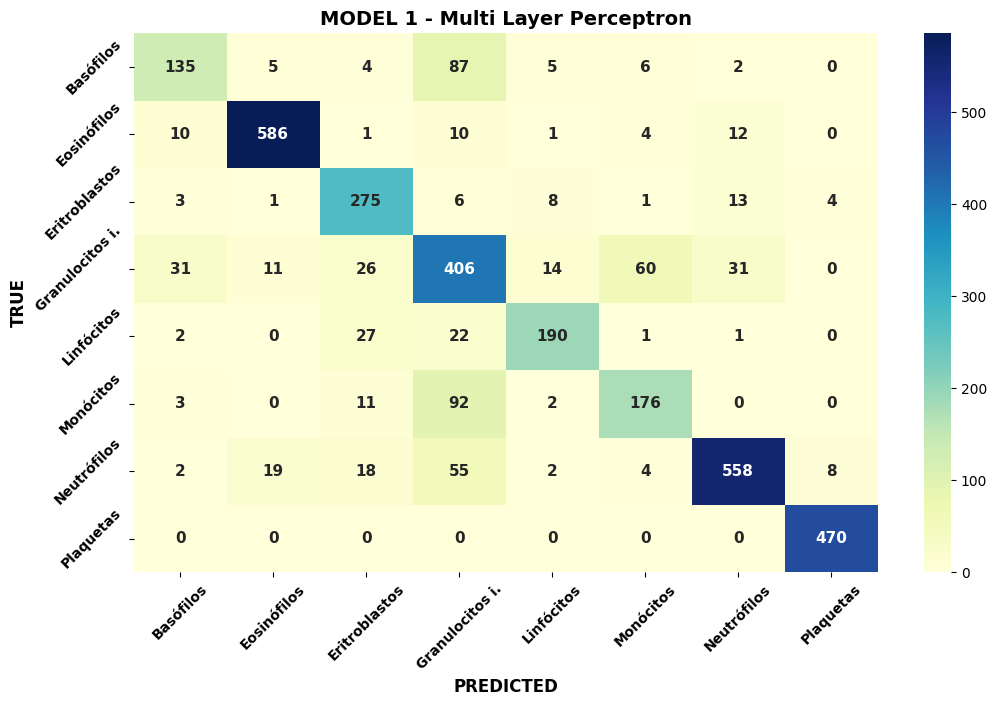

In [19]:
plot_confusion_matrix(testloader, model_1, 'MODEL 1 - Multi Layer Perceptron')

# PART B)

In [ ]:
# Monte uma CNN simples contendo:
#   (i) uma camada convolucional com função de ativação não-linear;
#  (ii) uma camada de pooling;
# (iii) uma camada de saída do tipo softmax.

# Avalie a progressão da acurácia junto aos dados de validação em função:
# • Da quantidade de kernels utilizados na camada convolucional;
# • Do tamanho do kernel de convolução.

## K = 3

In [20]:
trainloader, valloader, testloader = create_dataloaders(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

In [21]:
class SimpleCNNK3(nn.Module):
    def __init__(self):
        super(SimpleCNNK3, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6 * 13 * 13 , 120)
        self.fc2 = nn.Linear(120, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        #x = self.fc2(x)
        return x

model_2a = SimpleCNNK3()
model_2a

SimpleCNNK3(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1014, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [22]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_2a.parameters(), lr=LR, momentum=0.9)

In [23]:
#start = torch.cuda.Event(enable_timing=True)
#end = torch.cuda.Event(enable_timing=True)

#start.record()

train_losses, val_losses = [], []

# train
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0

    for images, labels in trainloader:
        # calculate log loss probabilities
        outputs = model_2a(images)
        labels = labels.squeeze(1)

        # calculate loss
        if task == 'multi-label, binary-class':
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
        else:
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)

        train_total += loss.item()

        # zero gradients
        optimizer.zero_grad()
        # calculate gradients - backward pass
        loss.backward()
        # take a step in direction minimizing loss
        optimizer.step()
    else:
        val_total = 0
        val_correct = 0  # Initialize number of correct predictions on the val set as 0

        # Turn off gradients for validation to save memory and computations
        with torch.no_grad():
            for images, labels in valloader:
                labels = labels.squeeze(1)

                # calculate log loss probabilities
                outputs = model_2a(images)
                # calculate loss
                if task == 'multi-label, binary-class':
                    labels = labels.to(torch.float32)
                    loss = criterion(outputs, labels)
                else:
                    labels = labels.squeeze().long()
                    loss = criterion(outputs, labels)
                val_total += loss.item()

                # calculate class probabilities
                ps = torch.exp(outputs)
                # calculate correct predictions
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_correct += equals.sum().item()

        # Calculate average loss between train and test sets
        train_loss = train_total / len(trainloader.dataset)
        val_loss = val_total / len(valloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print("Epoch: {}/{} | ".format(epoch+1, NUM_EPOCHS),
              "Train Loss: {:.5f} | ".format(train_loss),
              "Val Loss: {:.5f} | ".format(val_loss),
              "Val Acc: {:.5f}".format(val_correct / len(valloader.dataset)))

#end.record()
#torch.cuda.synchronize()
#print(f'\nFinished Training in {start.elapsed_time(end)/1000} secs')

Epoch: 1/20 |  Train Loss: 0.25766 |  Val Loss: 0.14933 |  Val Acc: 0.79498
Epoch: 2/20 |  Train Loss: 0.14111 |  Val Loss: 0.11838 |  Val Acc: 0.82652
Epoch: 3/20 |  Train Loss: 0.11081 |  Val Loss: 0.09841 |  Val Acc: 0.86040
Epoch: 4/20 |  Train Loss: 0.09495 |  Val Loss: 0.10131 |  Val Acc: 0.84638
Epoch: 5/20 |  Train Loss: 0.08169 |  Val Loss: 0.08656 |  Val Acc: 0.87617
Epoch: 6/20 |  Train Loss: 0.07370 |  Val Loss: 0.07631 |  Val Acc: 0.89194
Epoch: 7/20 |  Train Loss: 0.06499 |  Val Loss: 0.09712 |  Val Acc: 0.86682
Epoch: 8/20 |  Train Loss: 0.05869 |  Val Loss: 0.07393 |  Val Acc: 0.89953
Epoch: 9/20 |  Train Loss: 0.05222 |  Val Loss: 0.09147 |  Val Acc: 0.87734
Epoch: 10/20 |  Train Loss: 0.04697 |  Val Loss: 0.08245 |  Val Acc: 0.89486
Epoch: 11/20 |  Train Loss: 0.04214 |  Val Loss: 0.08067 |  Val Acc: 0.89603
Epoch: 12/20 |  Train Loss: 0.03761 |  Val Loss: 0.09535 |  Val Acc: 0.88201
Epoch: 13/20 |  Train Loss: 0.03352 |  Val Loss: 0.07207 |  Val Acc: 0.90654
Epoch: 1

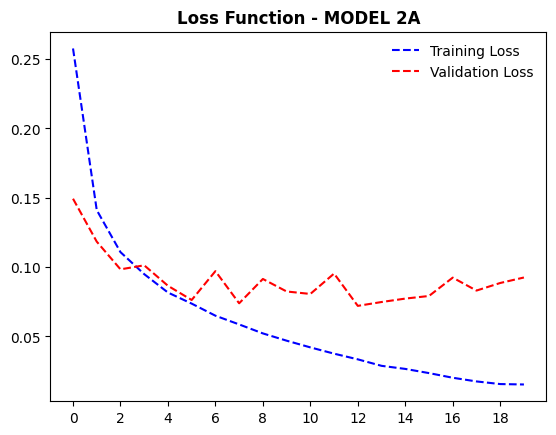

In [24]:
plot_loss_function(train_losses, val_losses, 'Loss Function - MODEL 2A')

In [25]:
get_accuracy(valloader, model_2a)

Total Accuracy in 1712 VALIDATION images: 89.895 %


In [26]:
get_accuracy(testloader, model_2a)

Total Accuracy in 3424 TESTING images: 90.324 %


In [27]:
print_class_accuracy_table(testloader, model_2a)

+-----------------+----------+
|    Class Cell   | Accuracy |
+-----------------+----------+
|    Basófilos    |  75.0 %  |
|   Eosinófilos   |  97.6 %  |
|  Eritroblastos  |  90.0 %  |
| Granulocitos i. |  81.9 %  |
|    Linfócitos   |  87.7 %  |
|    Monócitos    |  79.6 %  |
|   Neutrófilos   |  95.3 %  |
|    Plaquetas    | 100.0 %  |
+-----------------+----------+


## K = 5

In [29]:
trainloader, valloader, testloader = create_dataloaders(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

In [30]:
class SimpleCNNK5(nn.Module):
    def __init__(self):
        super(SimpleCNNK5, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 12 * 12 , 120) # 864
        self.fc2 = nn.Linear(120, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        #x = self.fc2(x)
        return x

model_2b = SimpleCNNK5()
model_2b

SimpleCNNK5(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)

In [31]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_2b.parameters(), lr=LR, momentum=0.9)

In [32]:
train_losses, val_losses = [], []

# train
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0

    for images, labels in trainloader:
        # calculate log loss probabilities
        outputs = model_2b(images)
        labels = labels.squeeze(1)

        # calculate loss
        if task == 'multi-label, binary-class':
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
        else:
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)

        train_total += loss.item()

        # zero gradients
        optimizer.zero_grad()
        # calculate gradients - backward pass
        loss.backward()
        # take a step in direction minimizing loss
        optimizer.step()
    else:
        val_total = 0
        val_correct = 0  # Initialize number of correct predictions on the val set as 0

        # Turn off gradients for validation to save memory and computations
        with torch.no_grad():
            for images, labels in valloader:
                labels = labels.squeeze(1)

                # calculate log loss probabilities
                outputs = model_2b(images)
                # calculate loss
                if task == 'multi-label, binary-class':
                    labels = labels.to(torch.float32)
                    loss = criterion(outputs, labels)
                else:
                    labels = labels.squeeze().long()
                    loss = criterion(outputs, labels)
                val_total += loss.item()

                # calculate class probabilities
                ps = torch.exp(outputs)
                # calculate correct predictions
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_correct += equals.sum().item()

        # Calculate average loss between train and test sets
        train_loss = train_total / len(trainloader.dataset)
        val_loss = val_total / len(valloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print("Epoch: {}/{} | ".format(epoch+1, NUM_EPOCHS),
              "Train Loss: {:.5f} | ".format(train_loss),
              "Val Loss: {:.5f} | ".format(val_loss),
              "Val Acc: {:.5f}".format(val_correct / len(valloader.dataset)))

Epoch: 1/20 |  Train Loss: 0.21098 |  Val Loss: 0.11965 |  Val Acc: 0.82827
Epoch: 2/20 |  Train Loss: 0.11747 |  Val Loss: 0.10070 |  Val Acc: 0.84813
Epoch: 3/20 |  Train Loss: 0.09566 |  Val Loss: 0.08949 |  Val Acc: 0.85864
Epoch: 4/20 |  Train Loss: 0.08421 |  Val Loss: 0.08195 |  Val Acc: 0.87850
Epoch: 5/20 |  Train Loss: 0.07654 |  Val Loss: 0.07163 |  Val Acc: 0.89136
Epoch: 6/20 |  Train Loss: 0.06874 |  Val Loss: 0.09538 |  Val Acc: 0.86273
Epoch: 7/20 |  Train Loss: 0.06205 |  Val Loss: 0.06682 |  Val Acc: 0.90713
Epoch: 8/20 |  Train Loss: 0.05624 |  Val Loss: 0.07779 |  Val Acc: 0.88843
Epoch: 9/20 |  Train Loss: 0.05168 |  Val Loss: 0.07413 |  Val Acc: 0.89778
Epoch: 10/20 |  Train Loss: 0.04677 |  Val Loss: 0.08051 |  Val Acc: 0.88902
Epoch: 11/20 |  Train Loss: 0.04273 |  Val Loss: 0.08472 |  Val Acc: 0.88259
Epoch: 12/20 |  Train Loss: 0.04002 |  Val Loss: 0.07097 |  Val Acc: 0.90245
Epoch: 13/20 |  Train Loss: 0.03690 |  Val Loss: 0.07760 |  Val Acc: 0.90245
Epoch: 1

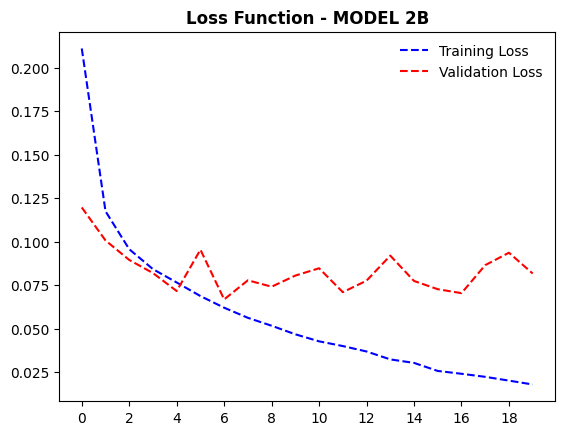

In [33]:
plot_loss_function(train_losses, val_losses, 'Loss Function - MODEL 2B')

In [34]:
get_accuracy(valloader, model_2b)

Total Accuracy in 1712 VALIDATION images: 90.829 %


In [35]:
get_accuracy(testloader, model_2b)

Total Accuracy in 3424 TESTING images: 89.594 %


In [36]:
print_class_accuracy_table(testloader, model_2b)

+-----------------+----------+
|    Class Cell   | Accuracy |
+-----------------+----------+
|    Basófilos    |  89.3 %  |
|   Eosinófilos   |  98.4 %  |
|  Eritroblastos  |  93.2 %  |
| Granulocitos i. |  68.0 %  |
|    Linfócitos   |  87.7 %  |
|    Monócitos    |  83.5 %  |
|   Neutrófilos   |  94.7 %  |
|    Plaquetas    |  99.6 %  |
+-----------------+----------+


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


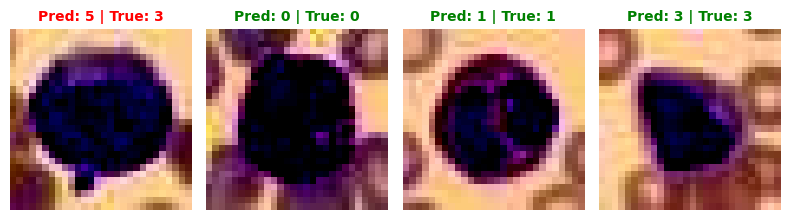

In [37]:
model_2b.eval()
correct = 0
total = 0

for images, labels in testloader:
    labels = labels.squeeze(1)

    outputs = model_2b(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    fig, axes = plt.subplots(1, 4, figsize=(8, 5))
    for i, (image, pred, actual) in enumerate(zip(images, predicted, labels)):
        axes[i].imshow(image.permute(1, 2, 0).numpy().astype(np.float32))
        if pred == actual:
            color = 'green'
        else:
            color = 'red'
        axes[i].set_title(f"Pred: {pred.item()} | True: {actual.item()}", fontsize=10, color=color, weight='bold')
        axes[i].axis("off")


    plt.tight_layout()
    plt.show()

    break

# PART C)



In [77]:
trainloader, valloader, testloader = create_dataloaders(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

In [78]:
class DeepNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DeepNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model_3 = DeepNet(in_channels=n_channels, num_classes=n_classes)

In [79]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_3.parameters(), lr=LR, momentum=0.9)

In [80]:
train_losses, val_losses = [], []

# train
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0

    for images, labels in trainloader:
        # calculate log loss probabilities
        outputs = model_3(images)
        labels = labels.squeeze(1)

        # calculate loss
        if task == 'multi-label, binary-class':
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
        else:
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)

        train_total += loss.item()

        # zero gradients
        optimizer.zero_grad()
        # calculate gradients - backward pass
        loss.backward()
        # take a step in direction minimizing loss
        optimizer.step()
    else:
        val_total = 0
        val_correct = 0  # Initialize number of correct predictions on the val set as 0

        # Turn off gradients for validation to save memory and computations
        with torch.no_grad():
            for images, labels in valloader:
                labels = labels.squeeze(1)

                # calculate log loss probabilities
                outputs = model_3(images)
                # calculate loss
                if task == 'multi-label, binary-class':
                    labels = labels.to(torch.float32)
                    loss = criterion(outputs, labels)
                else:
                    labels = labels.squeeze().long()
                    loss = criterion(outputs, labels)
                val_total += loss.item()

                # calculate class probabilities
                ps = torch.exp(outputs)
                # calculate correct predictions
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_correct += equals.sum().item()

        # Calculate average loss between train and test sets
        train_loss = train_total / len(trainloader.dataset)
        val_loss = val_total / len(valloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print("Epoch: {}/{} | ".format(epoch+1, NUM_EPOCHS),
              "Train Loss: {:.5f} | ".format(train_loss),
              "Val Loss: {:.5f} | ".format(val_loss),
              "Val Acc: {:.5f}".format(val_correct / len(valloader.dataset)))

Epoch: 1/20 |  Train Loss: 0.17152 |  Val Loss: 0.11993 |  Val Acc: 0.82418
Epoch: 2/20 |  Train Loss: 0.10659 |  Val Loss: 0.09592 |  Val Acc: 0.86215
Epoch: 3/20 |  Train Loss: 0.08682 |  Val Loss: 0.07383 |  Val Acc: 0.89311
Epoch: 4/20 |  Train Loss: 0.07239 |  Val Loss: 0.06748 |  Val Acc: 0.90537
Epoch: 5/20 |  Train Loss: 0.06366 |  Val Loss: 0.06507 |  Val Acc: 0.89953
Epoch: 6/20 |  Train Loss: 0.05492 |  Val Loss: 0.06665 |  Val Acc: 0.89953
Epoch: 7/20 |  Train Loss: 0.05094 |  Val Loss: 0.05007 |  Val Acc: 0.93283
Epoch: 8/20 |  Train Loss: 0.04473 |  Val Loss: 0.06498 |  Val Acc: 0.90888
Epoch: 9/20 |  Train Loss: 0.04101 |  Val Loss: 0.04603 |  Val Acc: 0.93341
Epoch: 10/20 |  Train Loss: 0.03694 |  Val Loss: 0.05699 |  Val Acc: 0.92231
Epoch: 11/20 |  Train Loss: 0.03272 |  Val Loss: 0.05192 |  Val Acc: 0.93049
Epoch: 12/20 |  Train Loss: 0.03126 |  Val Loss: 0.04772 |  Val Acc: 0.93458
Epoch: 13/20 |  Train Loss: 0.02569 |  Val Loss: 0.04549 |  Val Acc: 0.93283
Epoch: 1

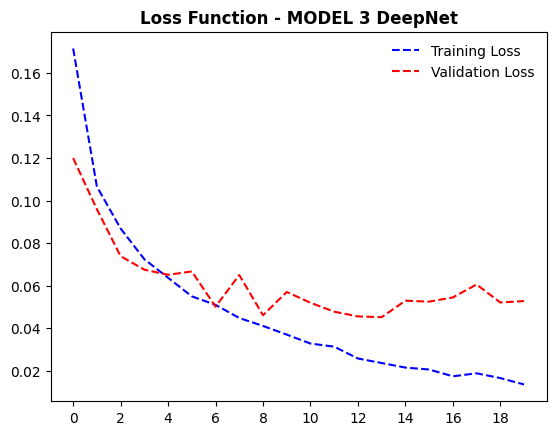

In [81]:
plot_loss_function(train_losses, val_losses, 'Loss Function - MODEL 3 DeepNet')

In [82]:
get_accuracy(testloader, model_3)

Total Accuracy in 3424 TESTING images: 93.394 %


In [83]:
print_class_accuracy_table(testloader, model_3)

+-----------------+----------+
|    Class Cell   | Accuracy |
+-----------------+----------+
|    Basófilos    |  91.8 %  |
|   Eosinófilos   |  98.1 %  |
|  Eritroblastos  |  89.7 %  |
| Granulocitos i. |  88.9 %  |
|    Linfócitos   |  93.8 %  |
|    Monócitos    |  83.5 %  |
|   Neutrófilos   |  94.9 %  |
|    Plaquetas    |  99.6 %  |
+-----------------+----------+


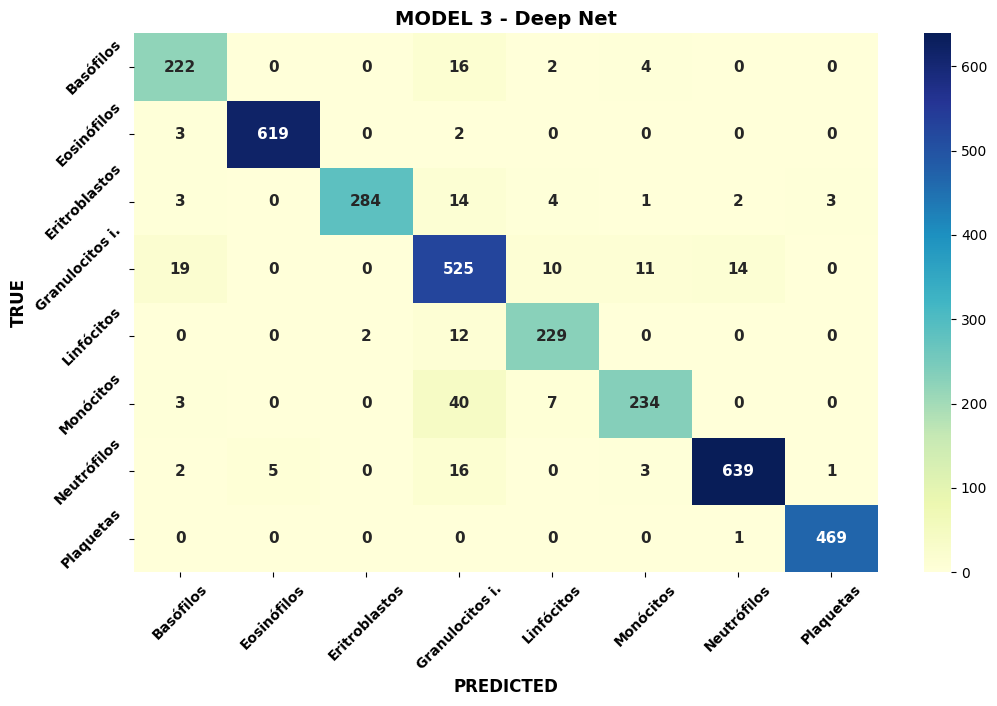

In [88]:
plot_confusion_matrix(testloader, model_3, 'MODEL 3 - Deep Net')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

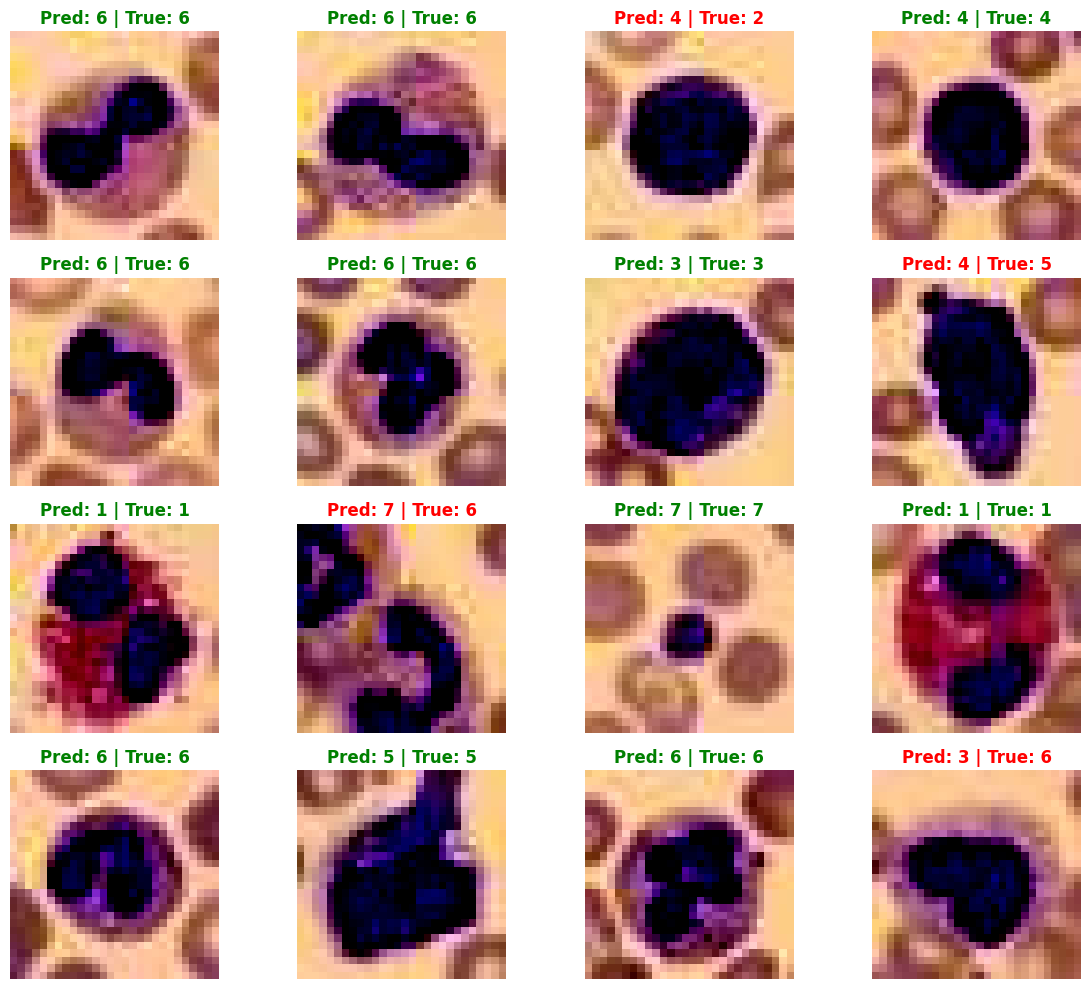

In [89]:
model_3.eval()
correct = 0
total = 0

nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10))
nr = 0

for images, labels in testloader:
    missmatch = 0
    labels = labels.squeeze(1)

    outputs = model_3(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
    for i, (image, pred, actual) in enumerate(zip(images, predicted, labels)):
        if pred.item() - actual.item() != 0:
            missmatch += 1
    
    if missmatch != 0:
        for i, (image, pred, actual) in enumerate(zip(images, predicted, labels)):        
            axes[nr][i].imshow(image.permute(1, 2, 0).numpy().astype(np.float32))
            
            if pred == actual:
                color = 'green'
            else:
                color = 'red'
            axes[nr][i].set_title(f"Pred: {pred.item()} | True: {actual.item()}", 
                                fontsize=12, color=color, weight='bold')
            axes[nr][i].axis("off")
        
        plt.tight_layout()
        
        nr += 1

    if nr == nrows:
        break

In [205]:
images_load = []
labels_img  = []
for images, labels in testloader:
    images_load.append(images)
    labels_img.append(labels)

In [226]:
input_batch = images_load[0].unsqueeze(0)
input_batch = input_batch[0]

label_batch = labels_img[0].unsqueeze(0)
label_batch = label_batch[0]

In [227]:
model_3.eval()

with torch.no_grad():
    output = model_3(input_batch)

print(output.shape)

probabilities = torch.nn.functional.softmax(output[0], dim=0)

torch.Size([4, 8])


In [228]:
k = 8
top5_prob, top5_catid = torch.topk(probabilities, k)

for id, prob in zip(top5_catid, top5_prob):
    print(f'Image class: {mapping[id.item()]} [{id.item()}] ----- {prob * 100:.4f} %')
    
input_batch_img = input_batch[0]
input_batch_img.shape

Image class: Granulocitos i. [3] ----- 90.8891 %
Image class: Monócitos [5] ----- 8.7017 %
Image class: Basófilos [0] ----- 0.3171 %
Image class: Eritroblastos [2] ----- 0.0588 %
Image class: Neutrófilos [6] ----- 0.0275 %
Image class: Linfócitos [4] ----- 0.0037 %
Image class: Plaquetas [7] ----- 0.0012 %
Image class: Eosinófilos [1] ----- 0.0009 %


torch.Size([3, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


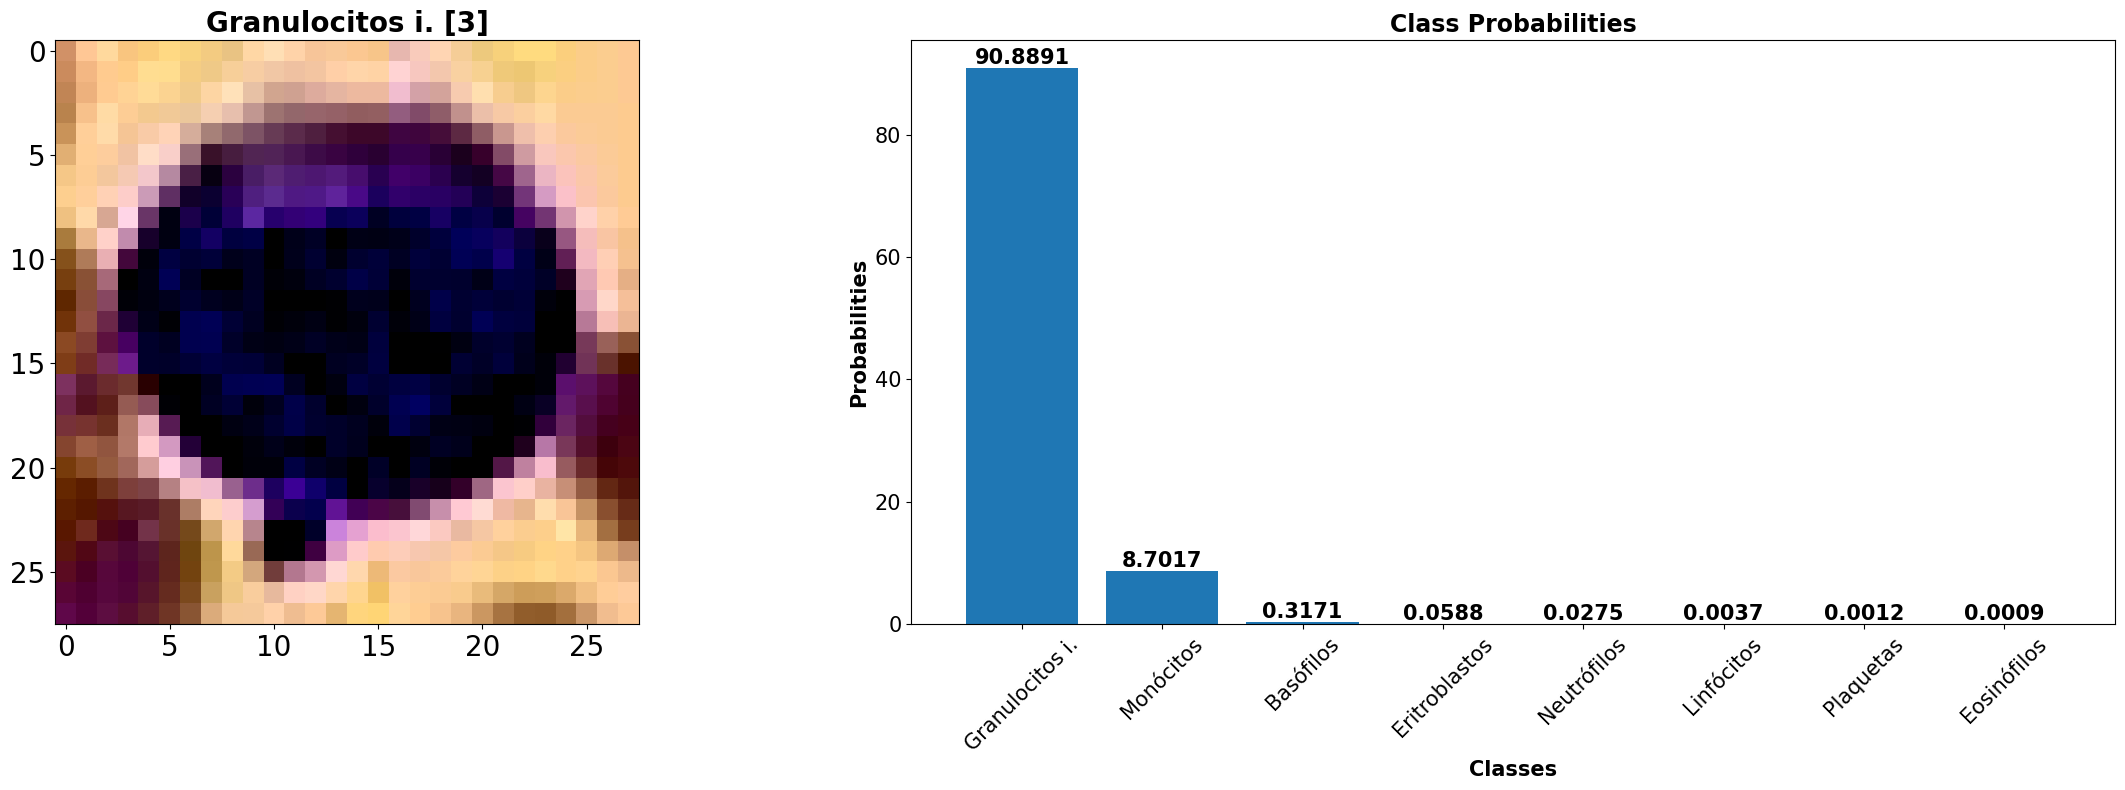

In [229]:
classes = [mapping[id.item()] for id in top5_catid]
probabilities = [round(prob.item() * 100, 4) for prob in top5_prob]
# creating the bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), constrained_layout=True)
ax1.set_title(f'{mapping[label_batch[0].item()]} [{label_batch[0].item()}]', fontsize=20, weight='bold')
ax1.imshow(np.squeeze(input_batch_img.permute(1, 2, 0)))
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
#ax1.axis('off')

ax2.bar(classes, probabilities)
for bars in ax2.containers:
    ax2.bar_label(bars, weight='bold', fontsize=15)
ax2.set_title('Class Probabilities', fontsize=17, weight='bold')
ax2.set_xlabel("Classes", fontsize=15, weight='bold')
ax2.set_ylabel("Probabilities", fontsize=15, weight='bold')
ax2.set_xticklabels(classes, rotation=45)

ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

plt.tight_layout()
plt.show()

# PART D)

In [258]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = BloodMNIST(split="train", download=DOWNLOAD, transform=transform_train)
val_dataset = BloodMNIST(split="val", download=DOWNLOAD, transform=transform_test)
test_dataset = BloodMNIST(split="test", download=DOWNLOAD, transform=transform_test)

Using downloaded and verified file: C:\Users\Marck\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Marck\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Marck\.medmnist\bloodmnist.npz


In [259]:
def create_dataloaders(train_dataset, val_dataset, test_dataset, BATCH_SIZE):
  trainloader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                               shuffle=True, num_workers=2)
  valloader   = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, num_workers=2)
  testloader  = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, num_workers=2)

  return trainloader, valloader, testloader

In [260]:
trainloader, valloader, testloader = create_dataloaders(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

In [ ]:
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x6400 and 9216x4096)

In [267]:
9216  =  256 x 6 x 6

36.0

In [265]:
6400  =  256 x 5 x 5

25.0

In [268]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=8):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6400, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model_4 = AlexNet()

In [269]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_4.parameters(), lr=LR, momentum=0.9)

In [270]:
train_losses, val_losses = [], []

# train
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0

    for images, labels in trainloader:
        # calculate log loss probabilities
        outputs = model_4(images)
        labels = labels.squeeze(1)

        # calculate loss
        if task == 'multi-label, binary-class':
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
        else:
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)

        train_total += loss.item()

        # zero gradients
        optimizer.zero_grad()
        # calculate gradients - backward pass
        loss.backward()
        # take a step in direction minimizing loss
        optimizer.step()
    else:
        val_total = 0
        val_correct = 0  # Initialize number of correct predictions on the val set as 0

        # Turn off gradients for validation to save memory and computations
        with torch.no_grad():
            for images, labels in valloader:
                labels = labels.squeeze(1)

                # calculate log loss probabilities
                outputs = model_4(images)
                # calculate loss
                if task == 'multi-label, binary-class':
                    labels = labels.to(torch.float32)
                    loss = criterion(outputs, labels)
                else:
                    labels = labels.squeeze().long()
                    loss = criterion(outputs, labels)
                val_total += loss.item()

                # calculate class probabilities
                ps = torch.exp(outputs)
                # calculate correct predictions
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_correct += equals.sum().item()

        # Calculate average loss between train and test sets
        train_loss = train_total / len(trainloader.dataset)
        val_loss = val_total / len(valloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print("Epoch: {}/{} | ".format(epoch+1, NUM_EPOCHS),
              "Train Loss: {:.5f} | ".format(train_loss),
              "Val Loss: {:.5f} | ".format(val_loss),
              "Val Acc: {:.5f}".format(val_correct / len(valloader.dataset)))

Epoch: 1/20 |  Train Loss: 0.20161 |  Val Loss: 0.11314 |  Val Acc: 0.82535
Epoch: 2/20 |  Train Loss: 0.11855 |  Val Loss: 0.12612 |  Val Acc: 0.81192
Epoch: 3/20 |  Train Loss: 0.09239 |  Val Loss: 0.08623 |  Val Acc: 0.87734
Epoch: 4/20 |  Train Loss: 0.07970 |  Val Loss: 0.08666 |  Val Acc: 0.86741
Epoch: 5/20 |  Train Loss: 0.06897 |  Val Loss: 0.05885 |  Val Acc: 0.91998
Epoch: 6/20 |  Train Loss: 0.06310 |  Val Loss: 0.04995 |  Val Acc: 0.92523
Epoch: 7/20 |  Train Loss: 0.05741 |  Val Loss: 0.05010 |  Val Acc: 0.93166
Epoch: 8/20 |  Train Loss: 0.05311 |  Val Loss: 0.06088 |  Val Acc: 0.91238
Epoch: 9/20 |  Train Loss: 0.04946 |  Val Loss: 0.04410 |  Val Acc: 0.93984
Epoch: 10/20 |  Train Loss: 0.04687 |  Val Loss: 0.05964 |  Val Acc: 0.91764
Epoch: 11/20 |  Train Loss: 0.04405 |  Val Loss: 0.06592 |  Val Acc: 0.90654
Epoch: 12/20 |  Train Loss: 0.04212 |  Val Loss: 0.04249 |  Val Acc: 0.93750
Epoch: 13/20 |  Train Loss: 0.04003 |  Val Loss: 0.04525 |  Val Acc: 0.93867
Epoch: 1

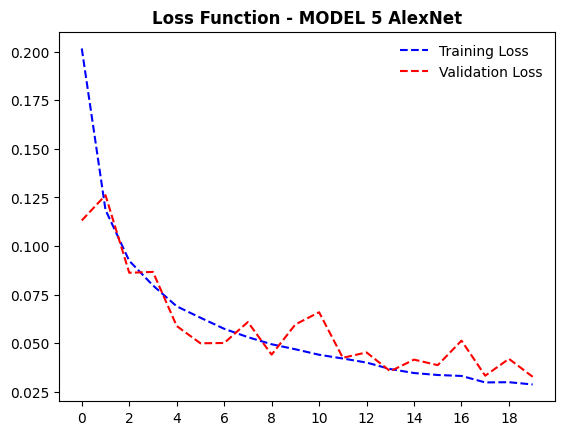

In [271]:
plot_loss_function(train_losses, val_losses, 'Loss Function - MODEL 5 AlexNet')

In [272]:
get_accuracy(testloader, model_4)

Total Accuracy in 3424 TESTING images: 95.118 %


In [273]:
print_class_accuracy_table(testloader, model_4)

+-----------------+----------+
|    Class Cell   | Accuracy |
+-----------------+----------+
|    Basófilos    |  91.8 %  |
|   Eosinófilos   |  99.2 %  |
|  Eritroblastos  |  94.2 %  |
| Granulocitos i. |  88.8 %  |
|    Linfócitos   |  93.0 %  |
|    Monócitos    |  88.4 %  |
|   Neutrófilos   |  98.5 %  |
|    Plaquetas    |  99.1 %  |
+-----------------+----------+


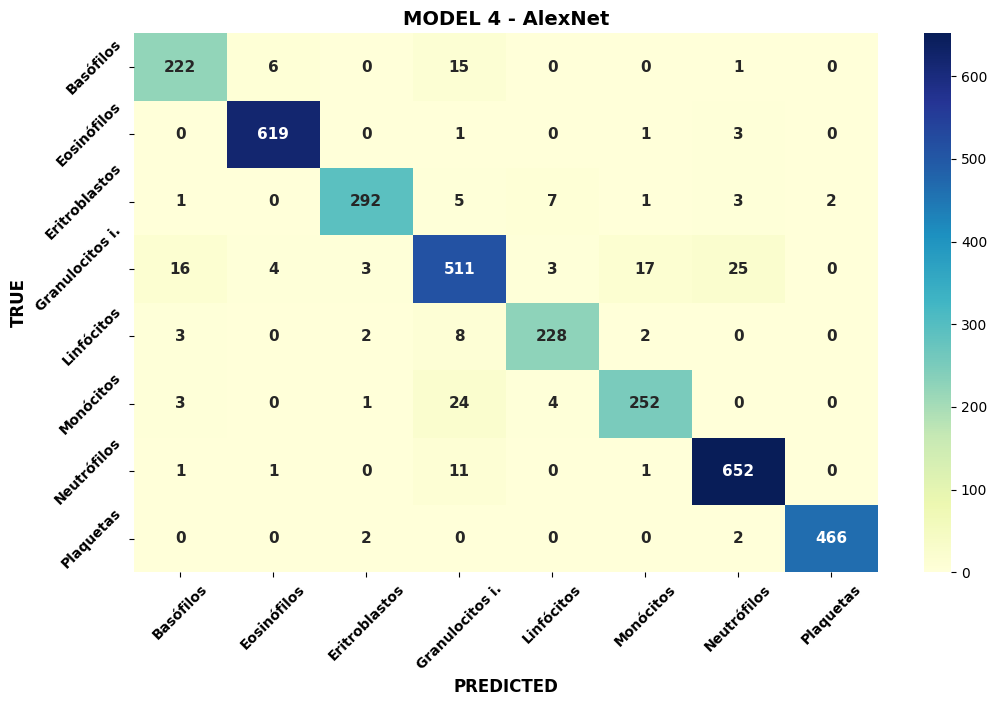

In [274]:
plot_confusion_matrix(testloader, model_4, 'MODEL 4 - AlexNet')

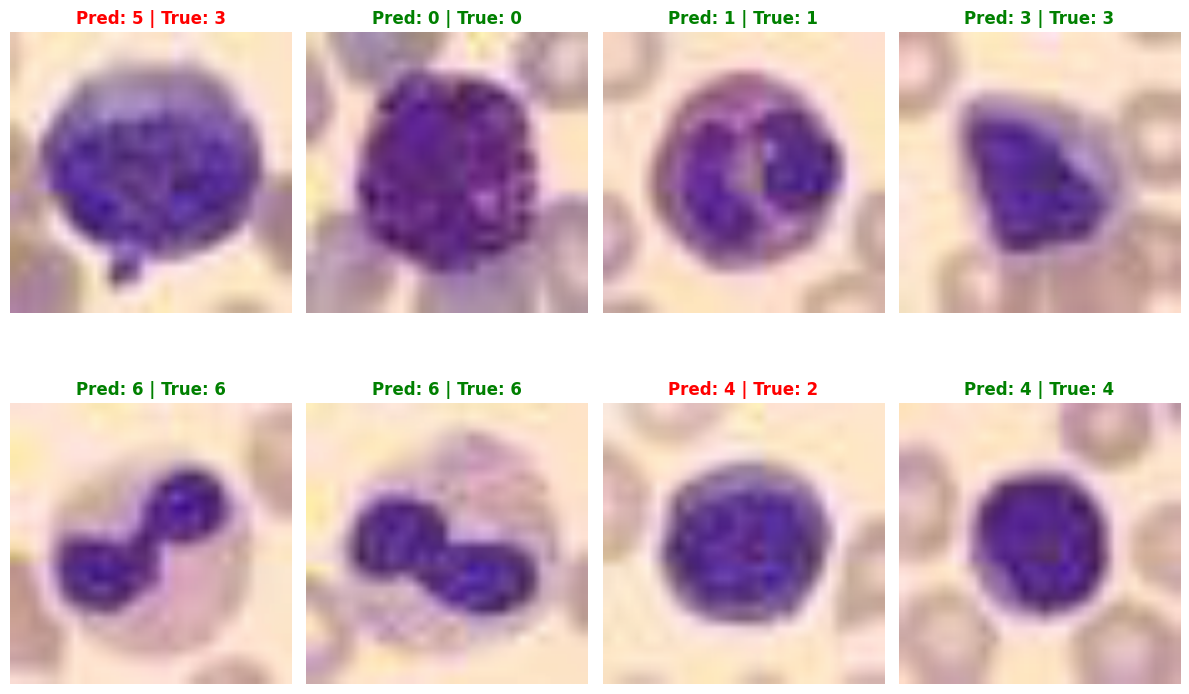

In [331]:
model_4.eval()
correct = 0
total = 0

nrows = 2
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10))
nr = 0

for images, labels in testloader:
    missmatch = 0
    labels = labels.squeeze(1)

    outputs = model_4(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
    for i, (image, pred, actual) in enumerate(zip(images, predicted, labels)):
        if pred.item() - actual.item() != 0:
            missmatch += 1
    
    if missmatch != 0:
        for i, (image, pred, actual) in enumerate(zip(images, predicted, labels)):     
            inv_normalize = transforms.Normalize(
                mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
                std=[1/0.2023, 1/0.1994, 1/0.2010]
            )
            image = inv_normalize(image)
            
            img = axes[nr][i].imshow(image.permute(1, 2, 0))
            #axes[nr][i].imshow(img)
            img.norm.autoscale([0, 1])
            
            if pred == actual:
                color = 'green'
            else:
                color = 'red'
            axes[nr][i].set_title(f"Pred: {pred.item()} | True: {actual.item()}", 
                                fontsize=12, color=color, weight='bold')
            axes[nr][i].axis("off")
        
        plt.tight_layout()
        
        nr += 1

    if nr == nrows:
        break

In [ ]:
#transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [326]:
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)

In [312]:
images_load = []
labels_img  = []
for images, labels in testloader:
    images_load.append(images)
    labels_img.append(labels)

In [327]:
input_batch = images_load[1].unsqueeze(0)
input_batch = input_batch[0]
input_batch = inv_normalize(input_batch)

label_batch = labels_img[1].unsqueeze(0)
label_batch = label_batch[0]

In [328]:
model_4.eval()

with torch.no_grad():
    output = model_4(input_batch)

print(output.shape)

probabilities = torch.nn.functional.softmax(output[0], dim=0)

torch.Size([4, 8])


In [329]:
k = 8
top5_prob, top5_catid = torch.topk(probabilities, k)

for id, prob in zip(top5_catid, top5_prob):
    print(f'Image class: {mapping[id.item()]} [{id.item()}] ----- {prob * 100:.4f} %')
    
input_batch_img = input_batch[0]
input_batch_img.shape

Image class: Eritroblastos [2] ----- 68.7344 %
Image class: Granulocitos i. [3] ----- 11.8069 %
Image class: Eosinófilos [1] ----- 8.3264 %
Image class: Plaquetas [7] ----- 5.6565 %
Image class: Basófilos [0] ----- 2.0119 %
Image class: Monócitos [5] ----- 1.9982 %
Image class: Linfócitos [4] ----- 1.0402 %
Image class: Neutrófilos [6] ----- 0.4254 %


torch.Size([3, 224, 224])

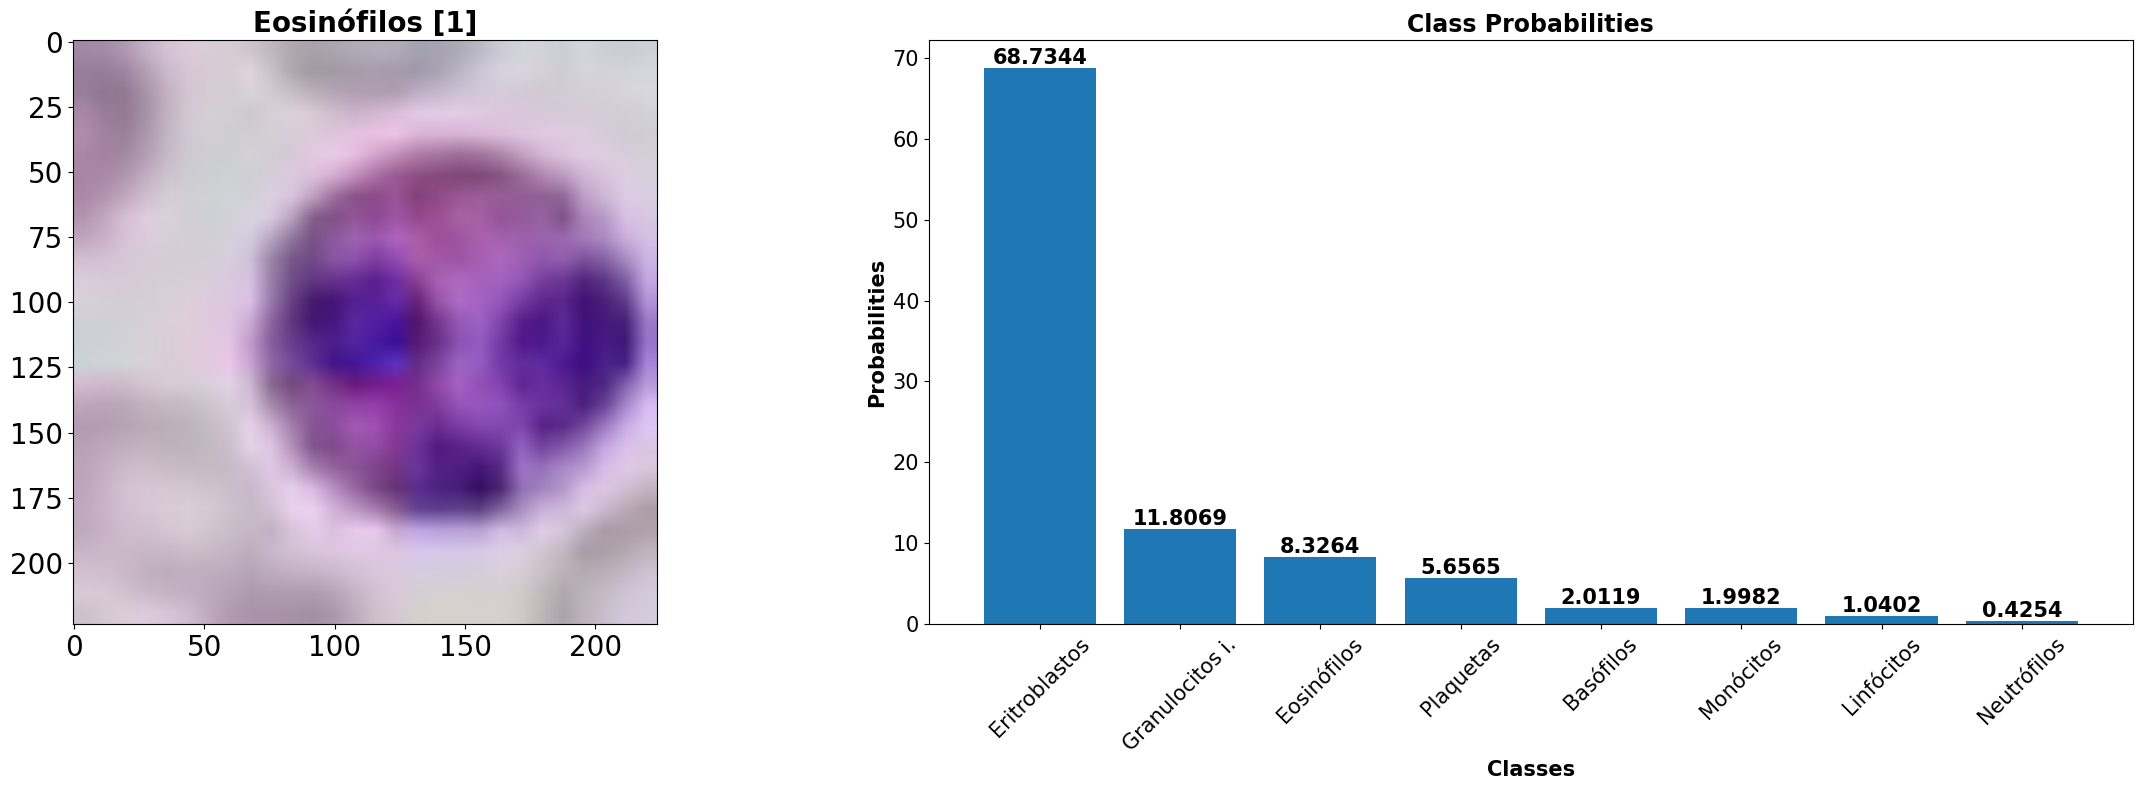

In [330]:
classes = [mapping[id.item()] for id in top5_catid]
probabilities = [round(prob.item() * 100, 4) for prob in top5_prob]
# creating the bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), constrained_layout=True)
ax1.set_title(f'{mapping[label_batch[0].item()]} [{label_batch[0].item()}]', fontsize=20, weight='bold')
ax1.imshow(np.squeeze(input_batch_img.permute(1, 2, 0)))
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
#ax1.axis('off')

ax2.bar(classes, probabilities)
for bars in ax2.containers:
    ax2.bar_label(bars, weight='bold', fontsize=15)
ax2.set_title('Class Probabilities', fontsize=17, weight='bold')
ax2.set_xlabel("Classes", fontsize=15, weight='bold')
ax2.set_ylabel("Probabilities", fontsize=15, weight='bold')
ax2.set_xticklabels(classes, rotation=45)

ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

plt.tight_layout()
plt.show()